In [6]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
import csv

## Functions used

In [7]:
# functions

def get_sec(time_str):
    """Get seconds from time."""
    m, s = time_str.split(':')
    time = float(m) * 60 + float(s)
    return time

def open_race_df(race): #from our list of race names, links to our github and calls the specified race csv
    x = race.split(' ')
    if len(x) == 2:
        race_df = pd.read_csv('https://raw.githubusercontent.com/blaustin/f1/main/races/' + x[0] + '%20' + x[1] + '.csv')
    elif len(x) == 3:
        race_df = pd.read_csv('https://raw.githubusercontent.com/blaustin/f1/main/races/' + x[0] + '%20' + x[1] + '%20' + x[2] + '.csv')
    else:
        print('Error: race name invalid')
        sys.exit(1)

    return race_df

## Initializing Global Variables

In [8]:
# assign dataset names
laps = {'Bahrian 2021': 56, 'Emilia Romagna 2021': 63,'Portugal 2021': 66,'Espana 2021': 66,'Monaco 2021': 78,'Azerbaijan 2021': 51,'France 2021': 53,'Styria 2021': 71,'Austria 2021': 71,'Britain 2021': 52,'Hungary 2021': 70,'Dutch 2021': 72,'Italy 2021': 53,'Russia 2021': 53,'Turkey 2021': 58,'United States 2021': 56,'Mexico 2021': 71,'Sao Paolo 2021': 71,'Qatar 2021': 57,'Saudi Arabia 2021': 50,'Abu Dhabi 2021': 58}
race_names = ['Bahrian 2021','Emilia Romagna 2021','Portugal 2021','Espana 2021','Monaco 2021','Azerbaijan 2021','France 2021','Styria 2021','Austria 2021','Britain 2021','Hungary 2021','Dutch 2021','Italy 2021','Russia 2021','Turkey 2021','United States 2021','Mexico 2021','Sao Paolo 2021','Qatar 2021','Saudi Arabia 2021','Abu Dhabi 2021']


# create empty list
races = []
# append datasets into the list
temp_df = pd.read_csv('https://raw.githubusercontent.com/blaustin/f1/main/races/Bahrian%202021.csv')
races.append(temp_df)
driver_numbers = list(races[0].columns[1:])

#Establish global variables
france = pd.read_csv('https://raw.githubusercontent.com/blaustin/f1/main/races/France%202021.csv')

global_driver_numbers = list(france.columns[1:])
#add kubica (substitute driver) because he wasn't in france 
global_driver_numbers.append('88')
global_driver_names = list(france.iloc[0])
global_driver_names.append('Robert Kubica')

#nameDict maps driver numbers to names
nameDict = {}
for i in range(len(global_driver_numbers)):
    nameDict[str(global_driver_numbers[i])] = global_driver_names[i]

#create global race dictionary 
raceDict = {}
for race in race_names:
    race_df = open_race_df(race)
    driver_numbers = list(race_df.columns[1:])
    
    raceDict[race] = {}
    raceDict[race]['driver_list'] = driver_numbers
    for driver_number in driver_numbers:
        raceDict[race][driver_number] = {}
        lap_times = list(race_df.loc[1:laps[race],str(driver_number)])
        raceDict[race][driver_number]['lap times'] = lap_times

for race in race_names:
    race_df = open_race_df(race)
    driver_numbers = list(race_df.columns[1:])
    for driver_number in driver_numbers:
        rolling_cum_time = [] #gives a rolling cumulative time in seconds for each lap of a race
        num_laps = laps[race]
        cum_time = 0
        raceDict[race][driver_number]['retired?'] = False
        
        for i in range(1,num_laps):
            time = race_df.loc[i,driver_number]
            if type(time) == float: #when a driver doesn't have a lap time, this means they either retired or finished lap(s) behind
                time = '0:0.0'
                if i < num_laps - 2: #THIS IS AN ASSUMPTION THAT NO RETIRES HAPPEN WITHIN LAST 3 LAPS
                    raceDict[race][driver_number]['retired?'] = True

            cum_time += get_sec(str(time))
            cum_time = round(cum_time,3)
            rolling_cum_time.append(cum_time)
        
        raceDict[race][driver_number]['cumulative lap times'] = rolling_cum_time #puts cumulative time into race dict

  

In [9]:
raceDict['Emilia Romagna 2021']['33']['cumulative lap times'] #test

[98.603,
 247.766,
 391.013,
 531.345,
 677.036,
 817.84,
 914.143,
 1007.068,
 1098.021,
 1188.151,
 1277.319,
 1366.133,
 1454.252,
 1541.992,
 1629.051,
 1715.648,
 1802.253,
 1889.255,
 1976.323,
 2063.42,
 2152.046,
 2240.303,
 2329.835,
 2419.629,
 2508.596,
 2596.778,
 2688.514,
 2799.766,
 2883.935,
 2970.368,
 3053.322,
 3157.537,
 3301.588,
 5074.328,
 5158.071,
 5239.077,
 5319.43,
 5399.156,
 5478.735,
 5557.67,
 5636.456,
 5715.136,
 5793.665,
 5872.068,
 5950.352,
 6028.363,
 6106.524,
 6184.611,
 6262.782,
 6341.358,
 6419.516,
 6497.479,
 6575.416,
 6653.182,
 6730.985,
 6808.894,
 6887.29,
 6965.322,
 7043.315,
 7120.839,
 7199.1,
 7276.626]

## Storing position and delta data for each driver for each lap in each race.

### Data is stored in lists, with the index of the item coinciding with the lap it occurred on

In [16]:
# for each lap in each race
# create an ordered list of the times (first element will be first position)

for race in race_names:
    print(race)
    race_df = open_race_df(race)
    driver_numbers = list(race_df.columns[1:])
    
    #initialize delta and position lists for each driver
    for driver in driver_numbers:
      raceDict[race][driver]['position'] = []
      raceDict[race][driver]['delta'] = []
      raceDict[race][driver]['delta2'] = []
      
    raceDict[race]['positions'] = {}

    num_laps = laps[race]
    for i in range (0,num_laps-1):
    #i=4
        driver_times = []
        for driver_number in driver_numbers:
            if pd.isna(raceDict[race][driver_number]['lap times'][i]) == False:
                #remove driver from next iteration of position list
                driver_times.append((raceDict[race][driver_number]['cumulative lap times'][i],driver_number))
                
        
        driver_times.sort(key=lambda y: y[0])

        #find positions list and store position for each driver
        positions = []
        for driver in driver_times:
            positions.append(driver[1])

        raceDict[race]['positions'][i+1] = positions

        #find deltas and store delta to driver ahead for each driver
        deltas_ = []
        for time in driver_times:
          deltas_.append(time[0])  
        deltas = np.diff(deltas_)
       
        #case for driver in first
        raceDict[race][positions[0]]['position'].append(1)
        raceDict[race][positions[0]]['delta'].append(0)

        #add data for every over driver in positons
        position = 0
        for driver in positions[1:]:
          raceDict[race][driver]['position'].append(position+2)
          raceDict[race][driver]['delta'].append(round(deltas[position],3))
          position += 1

        #2 ahead delats
        deltas2 = []
        for i in range(2,len(deltas_)):
          deltas2.append(deltas_[i]-deltas_[i-2])

        position = 0
        for driver in positions[2:]:
          raceDict[race][driver]['delta2'].append(round(deltas2[position],3))
          position += 1

        #Retires dictionary entires
        for driver in driver_numbers:
          if len(raceDict[race][driver]['position']) < (num_laps - 3):
            raceDict[race][driver]['retired'] = True
          else:
            raceDict[race][driver]['retired'] = False

    
race = 'Dutch 2021'

print(raceDict[race]['99']['position'])
print(raceDict[race]['88']['delta'])
print(raceDict[race]['88']['delta2'])
print(raceDict[race]['88']['retired'])

Bahrian 2021
Emilia Romagna 2021
Portugal 2021
Espana 2021
Monaco 2021
Azerbaijan 2021
France 2021
Styria 2021
Austria 2021
Britain 2021
Hungary 2021
Dutch 2021
Italy 2021
Russia 2021
Turkey 2021
United States 2021
Mexico 2021
Sao Paolo 2021
Qatar 2021
Saudi Arabia 2021
Abu Dhabi 2021
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 14, 14, 14, 13, 12, 14, 18, 18, 18, 18, 18, 18, 17, 17, 17, 17, 16, 16, 16, 16, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 14, 14]
[0.847, 0.644, 1.362, 1.544, 1.945, 1.645, 1.84, 2.066, 1.717, 2.881, 2.889, 2.808, 2.715, 2.759, 2.836, 2.621, 2.914, 3.263, 3.933, 3.211, 4.652, 5.825, 6.011, 6.209, 6.642, 6.453, 6.358, 6.648, 6.898, 9.333, 0.988, 2.5, 0.546, 4.112, 5.414, 7.14, 9.767, 11.257, 2.69, 0.656, 20.63, 19.647, 18.713, 15.476, 16.925, 17.08, 16.955, 13.447, 14.201, 13.855, 12.796, 10.823, 10.726, 11.021, 2.085, 3.366, 4.74, 5.517, 3.341, 2.782, 2.198

## Calculating when an overtake occurs and storage

In [ ]:

raceDict[race]['positions'][lap]

In [18]:
#code for marking an overtake

#for each race
#for each lap
#for each driver
  #competitor = positions[myposbefore - 1]
  #competitor2 = positions[myposbefore - 2]
  #ignore for 1st and secont
  #if myposnow < compposnow
    #overtake has occured
    #raceDict[race][driver]['overtakes'].append(raceDict[race][driver]['delta'])[lap]

  #elif myposnow < comp2posnow
    #overtake has occured
    #overtake_deltas.append(raceDict[race][driver]['delta2'])[lap]

count = 0
cutoff = 10 #cutoff (in seconds) to eliminate counting overtakes from pitting

overtakeDict = {}
for driver in global_driver_numbers:
  overtakeDict[driver] = {}
  overtakeDict[driver]['overtake_deltas'] = list()
  overtakeDict[driver]['all_deltas'] = list()
  overtakeDict[driver]['frequency'] = list()


for race in race_names:
  num_laps = laps[race]
  for lap in range (2,num_laps-1):
    for driver in raceDict[race]['positions'][lap]:
      
      #append delta for this driver for this lap
      try:
        overtakeDict[driver]['all_deltas'].append(raceDict[race][driver]['delta'][lap-1])
      except IndexError:
        pass
      
      driver_previous = raceDict[race]['positions'][lap-1].index(driver) #index of my position on previous lap
      driver_now = raceDict[race]['positions'][lap].index(driver)
      competitor = raceDict[race]['positions'][lap-1][driver_previous-1] #number of driver ahead of me on previous lap
      
      #check if competitor still in race
      if competitor in raceDict[race]['positions'][lap] and raceDict[race]['positions'][lap].index(driver) !=0 and raceDict[race][driver]['delta'][lap-1] < cutoff:
        if raceDict[race]['positions'][lap].index(driver) < raceDict[race]['positions'][lap].index(competitor):
          #if raceDict[race][driver]['delta'][lap-1] < cutoff:
          print(f'{driver} overtook {competitor} on lap {lap} in {race} to move from {driver_previous+1} to {driver_now+1}')
          #append delta for this driver for this lap
          try:
            overtakeDict[driver]['overtake_deltas'].append(raceDict[race][driver]['delta'][lap-1])
            count += 1
          except IndexError: #occurs when a driver is in first or is retired
            pass
          

print(count)

4 overtook 10 on lap 4 in Bahrian 2021 to move from 6 to 5
99 overtook 7 on lap 4 in Bahrian 2021 to move from 12 to 10
63 overtook 22 on lap 4 in Bahrian 2021 to move from 15 to 13
11 overtook 47 on lap 4 in Bahrian 2021 to move from 18 to 14
5 overtook 10 on lap 5 in Bahrian 2021 to move from 18 to 17
77 overtook 16 on lap 6 in Bahrian 2021 to move from 4 to 3
11 overtook 63 on lap 6 in Bahrian 2021 to move from 14 to 13
22 overtook 63 on lap 7 in Bahrian 2021 to move from 15 to 14
4 overtook 16 on lap 9 in Bahrian 2021 to move from 5 to 4
18 overtook 14 on lap 9 in Bahrian 2021 to move from 8 to 7
11 overtook 31 on lap 10 in Bahrian 2021 to move from 13 to 12
55 overtook 14 on lap 11 in Bahrian 2021 to move from 9 to 8
3 overtook 16 on lap 12 in Bahrian 2021 to move from 6 to 4
55 overtook 18 on lap 12 in Bahrian 2021 to move from 8 to 7
7 overtook 99 on lap 12 in Bahrian 2021 to move from 11 to 9
99 overtook 14 on lap 12 in Bahrian 2021 to move from 10 to 11
55 overtook 16 on lap 1

## Categorizing overtakes into bins based on the delta range where they occured and plotting

3


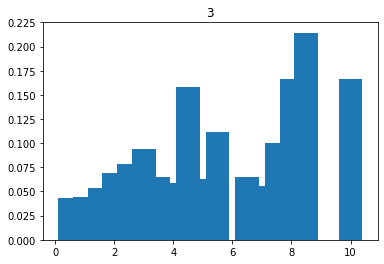

4


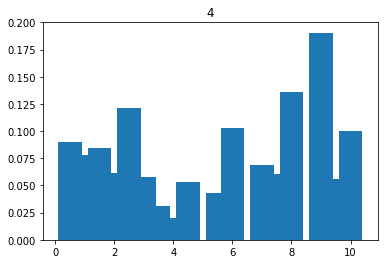

5


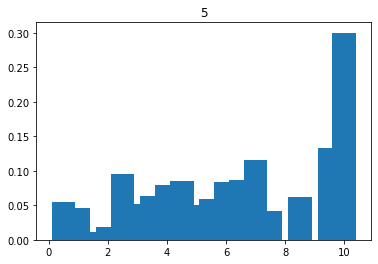

6


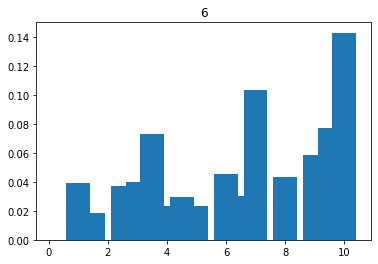

7


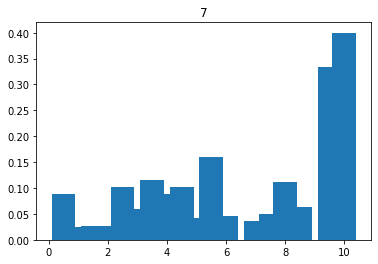

9


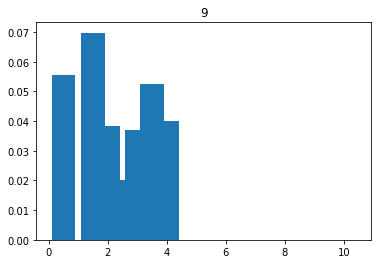

10


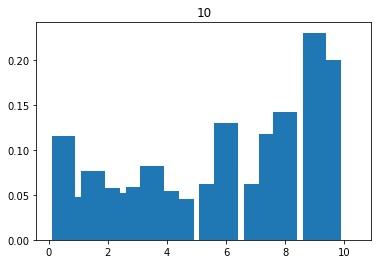

11


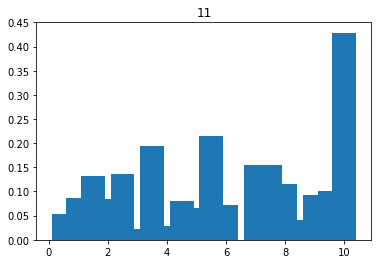

14


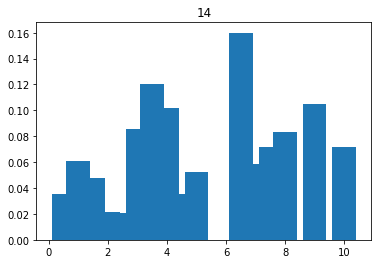

16


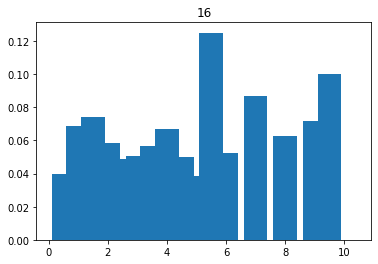

18


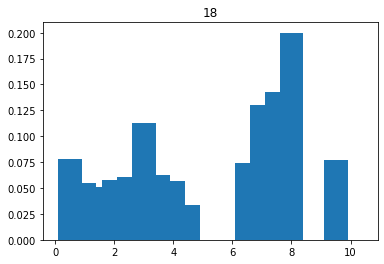

22


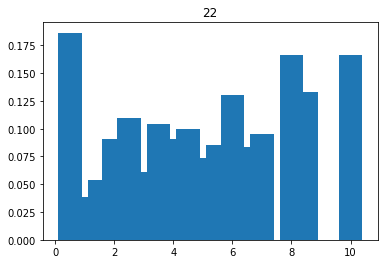

31


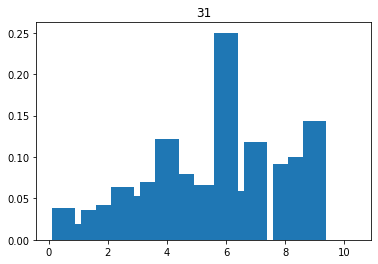

33


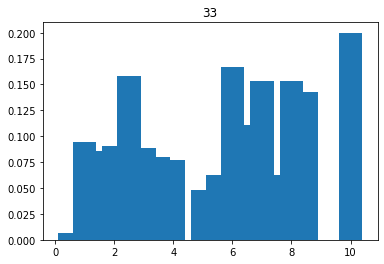

44


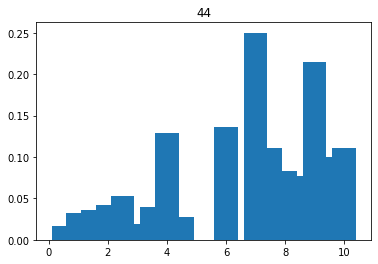

47


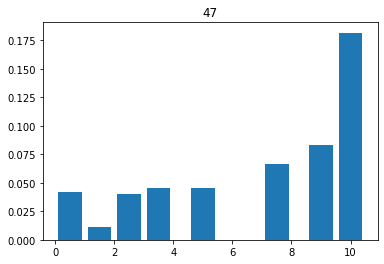

55


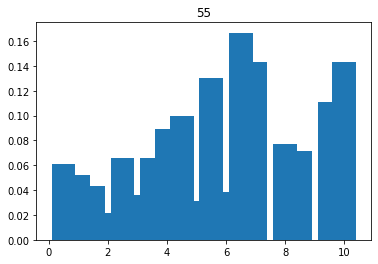

63


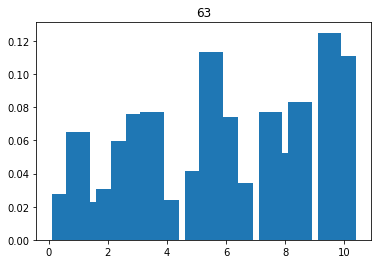

77


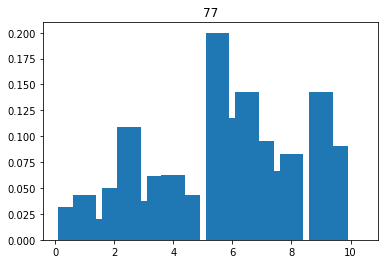

99


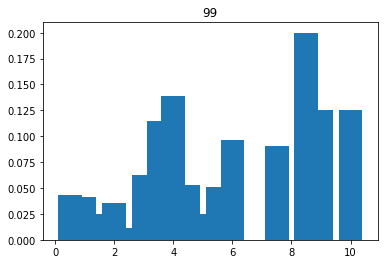

88


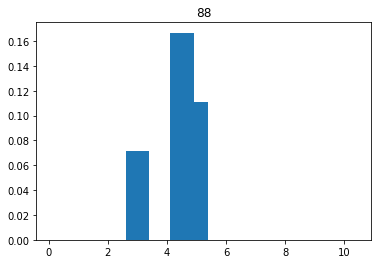

20
20


In [20]:
all_overtakes = 0
cutoff = 10
x_axis = [.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10]
for driver in global_driver_numbers:
  #print(driver,len(overtakeDict[driver]['all_deltas']),len(overtakeDict[driver]['overtake_deltas']))
  all_overtakes += len(overtakeDict[driver]['overtake_deltas'])

  bin_min=0
  bin_max=0.5
  step = 0.5

  while True:
    if bin_max > cutoff:
      break
    filt_overtake = [i for i in overtakeDict[driver]['overtake_deltas'] if i < bin_max and i >= bin_min]
    filt_all = [i for i in overtakeDict[driver]['all_deltas'] if i < bin_max and i >= bin_min]
    
    bin_min+=step
    bin_max+=step

    try:
      overtakeDict[driver]['frequency'].append(len(filt_overtake)/len(filt_all))
    except ZeroDivisionError:
      overtakeDict[driver]['frequency'].append(0)
    
  overtakeDict[driver]['frequency'] = overtakeDict[driver]['frequency'][:20]

    
    

  #plt.hist(overtakeDict[driver]['overtake_deltas'],bins = 20)
  print(driver)
  plt.bar(x_axis,overtakeDict[driver]['frequency'])
  plt.title(driver)
  plt.show()
print(len(overtakeDict['33']['frequency']))
print(len(x_axis))

## Final Analysis

In [21]:
#final outputs 

#Most/Fewest Overtakes
overtakes = list()
for driver in global_driver_numbers:
    overtakes.append((driver,len(overtakeDict[driver]['overtake_deltas'])))

(most_driver,most_overtakes) = max(overtakes,key=lambda item:item[1])
(fewest_driver,fewest_overtakes) = min(overtakes,key=lambda item:item[1])

print("The F1 driver with the most overtakes in 2021 was #" + most_driver + " with " + str(most_overtakes) + " overtakes.")
print("The F1 driver with the fewest overtakes in 2021 was #" + fewest_driver + " with " + str(fewest_overtakes) + " overtakes.")


#Best Overtake percentage was found w/ graphical analysis



The F1 driver with the most overtakes in 2021 was #11 with 88 overtakes.
The F1 driver with the fewest overtakes in 2021 was #88 with 3 overtakes.
